In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

data_train = pd.read_csv('../data/q1/train.csv')
data_test = pd.read_csv('../data/q1/test.csv')
data_validation = pd.read_csv('../data/q1/validation.csv')

categorical_cols = data_train.select_dtypes(include='object').columns.tolist()

data_train = pd.get_dummies(data_train, columns=categorical_cols, dtype=int)
data_validation = pd.get_dummies(data_validation, columns=categorical_cols, dtype=int)
data_test = pd.get_dummies(data_test, columns=categorical_cols, dtype=int)

data_test = data_test.reindex(columns=data_train.columns, fill_value=0)
data_validation = data_validation.reindex(columns=data_train.columns, fill_value=0)


X_train = data_train.drop('result', axis=1).values
y_train = data_train['result'].values

X_validation = data_validation.drop('result', axis=1).values
y_validation = data_validation['result'].values

X_test = data_test.drop('result', axis=1).values
y_test = data_test['result'].values

In [3]:


class Node:
    def __init__(self, feature=None, threshold=None, is_leaf=False, target=None):
        self.feature = feature
        self.threshold = threshold
        self.is_leaf = is_leaf
        self.target = target
        self.left = None
        self.right = None


class DecisionTree:
    def __init__(self, max_depth=5, X=None, y=None):
        self.max_depth = max_depth
        self.X = X
        self.y = y
        self.root = None

    def calculate_entropy(self, y):
        if len(y) == 0:
            return 0
        p = np.mean(y == 1)
        return -(p * math.log2(p) + (1 - p) * math.log2(1 - p)) if p not in [0, 1] else 0

    def calculate_information_gain(self, X, y, feature_index):
        feature_values = X[:, feature_index]
        threshold = np.median(feature_values)
        left_mask = feature_values <= threshold
        right_mask = feature_values > threshold

        y_left, y_right = y[left_mask], y[right_mask]
        H = (len(y_left) / len(y)) * self.calculate_entropy(y_left) + \
            (len(y_right) / len(y)) * self.calculate_entropy(y_right)
        return self.calculate_entropy(y) - H, threshold

    def get_best_split(self, X, y):
        best_gain = 0
        best_feature_index = None
        best_threshold = None

        n_features = X.shape[1]
        for feature_index in range(n_features):
            gain, threshold = self.calculate_information_gain(X, y, feature_index)
            if gain >= best_gain:
                best_gain = gain
                best_feature_index = feature_index
                best_threshold = threshold

        return best_feature_index, best_threshold

    def build_tree(self, X, y, depth):
        if depth == self.max_depth or self.calculate_entropy(y) == 0:
            target = 1 if np.sum(y == 1) >= np.sum(y == 0) else 0
            return Node(is_leaf=True, target=target)

        feature_index, threshold = self.get_best_split(X, y)
        if feature_index is None:
            target = 1 if np.sum(y == 1) >= np.sum(y == 0) else 0
            return Node(is_leaf=True, target=target)

        root = Node(feature=feature_index, threshold=threshold)
        root.target = 1 if np.sum(y == 1) >= np.sum(y == 0) else 0

        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold

        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]

        root.left = self.build_tree(X_left, y_left, depth + 1)
        root.right = self.build_tree(X_right, y_right, depth + 1)

        return root

    def fit(self):
        self.root = self.build_tree(self.X, self.y, 0)

    def predict(self, X):
        y_predictions = []
        for row in X:
            current_node = self.root
            while not current_node.is_leaf:
                feature = current_node.feature
                threshold = current_node.threshold
                if row[feature] <= threshold:
                    current_node = current_node.left
                else:
                    current_node = current_node.right
            y_predictions.append(current_node.target)
        return np.array(y_predictions)

    def accuracy(self, X, y):
        preds = self.predict(X)
        return np.mean(preds == y)

    def new_pruned_node(self, node, y_ref=None):
        node.is_leaf = True
        node.left = None
        node.right = None
        node.target = node.target  # No need to compute again since we don’t store node.y

    def get_nodes(self, node):
        if node.is_leaf:
            return []
        nodes = [node]
        nodes += self.get_nodes(node.left)
        nodes += self.get_nodes(node.right)
        return nodes

    def post_pruning(self, X_val, y_val,X_train,Y_train , X_test,Y_test):
        validation_accuracies = []
        test_accuracies = []
        train_accuracies = []

        count_nodes = []

        while True:
            all_nodes = [
                node for node in self.get_nodes(self.root)
                if node.left is not None
                and node.right is not None
                and node.left.is_leaf
                and node.right.is_leaf
            ]

            curr_accuracy = self.accuracy(X_val, y_val)
            best_accuracy = curr_accuracy
            best_node = None

            for node in all_nodes:
                backup = (node.left, node.right, node.is_leaf, node.target)
                self.new_pruned_node(node)
                new_accuracy = self.accuracy(X_val, y_val)
                node.left, node.right, node.is_leaf, node.target = backup

                if new_accuracy >= best_accuracy:
                    best_accuracy = new_accuracy
                    best_node = node

            if best_node is None or len(validation_accuracies) >= 4000:
                break

            self.new_pruned_node(best_node)
            count_nodes.append(2 * len(self.get_nodes(self.root)) + 1)
            validation_accuracies.append(best_accuracy)
            train_accuracies.append(self.accuracy(X_train, Y_train))
            test_accuracies.append(self.accuracy(X_test, Y_test))

        return count_nodes, train_accuracies, validation_accuracies, test_accuracies

    


Training Accuracy after pruning for depth 15 :  0.651718410629871 %
Validation Accuracy after pruning for depth 15 :  0.6425287356321839 %
Test Accuracy after pruning for depth 15 :  0.56153050672182 %


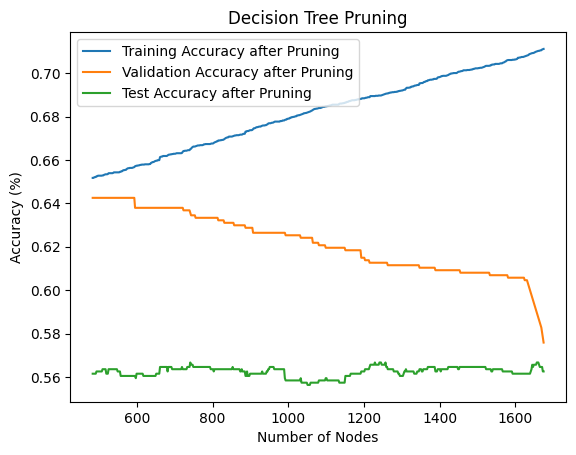

Training Accuracy after pruning for depth 25 :  0.7212214130573655 %
Validation Accuracy after pruning for depth 25 :  0.6988505747126437 %
Test Accuracy after pruning for depth 25 :  0.5915201654601862 %


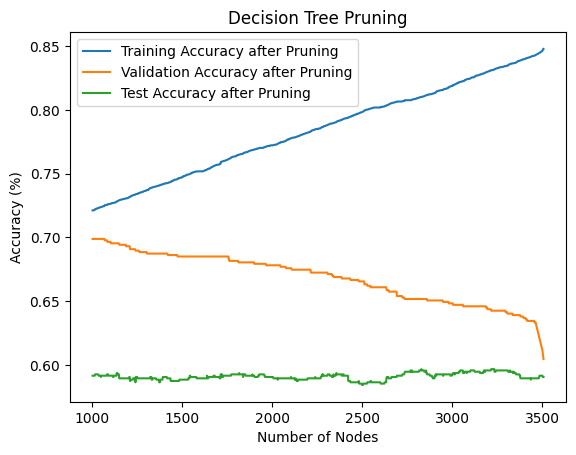

Training Accuracy after pruning for depth 35 :  0.7552063370384566 %
Validation Accuracy after pruning for depth 35 :  0.7137931034482758 %
Test Accuracy after pruning for depth 35 :  0.6049638055842813 %


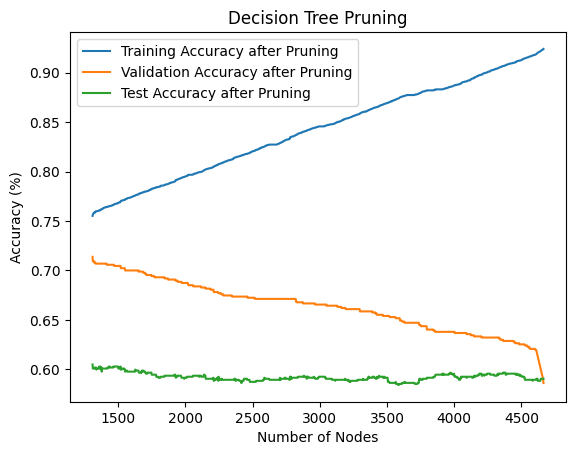

Training Accuracy after pruning for depth 45 :  0.7857416634725949 %
Validation Accuracy after pruning for depth 45 :  0.732183908045977 %
Test Accuracy after pruning for depth 45 :  0.610134436401241 %


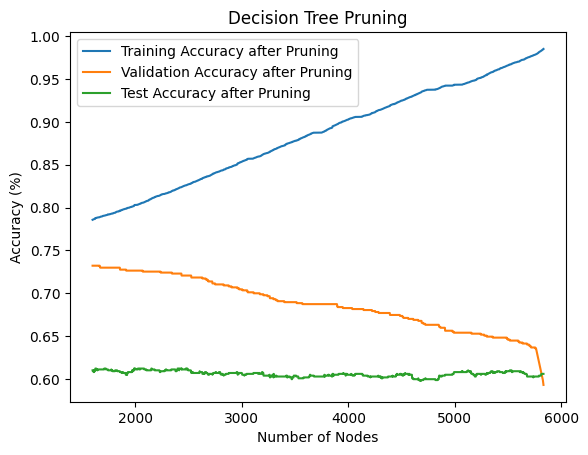

In [5]:
dpeth = [15,25,35,45]
for dpth in dpeth:
    Dtree = DecisionTree(max_depth=dpth, X=X_train, y=y_train)
    Dtree.fit()
    cnt_nodes , train_acc , val_acc, test_acc = Dtree.post_pruning(X_validation, y_validation,X_train,y_train , X_test,y_test)
    print(f"Training Accuracy after pruning for depth {dpth} : ", train_acc[-1] , '%')
    print(f"Validation Accuracy after pruning for depth {dpth} : ", val_acc[-1] , '%')
    print(f"Test Accuracy after pruning for depth {dpth} : ", test_acc[-1] , '%')

    plt.plot(cnt_nodes , train_acc, label='Training Accuracy after Pruning')
    plt.plot(cnt_nodes , val_acc, label='Validation Accuracy after Pruning')
    plt.plot(cnt_nodes , test_acc, label='Test Accuracy after Pruning')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Accuracy (%)')
    plt.title('Decision Tree Pruning')
    plt.legend()
    plt.show()

In [24]:

count_nodes, validation_accuracies = Dtree.post_pruning(X_validation, y_validation)

In [ ]:
count_nodes 

[5833,
 5831,
 5829,
 5827,
 5825,
 5823,
 5821,
 5819,
 5817,
 5815,
 5813,
 5811,
 5809,
 5807,
 5805,
 5803,
 5801,
 5799,
 5797,
 5795,
 5793,
 5791,
 5789,
 5787,
 5785,
 5783,
 5781,
 5779,
 5777,
 5775,
 5773,
 5771,
 5769,
 5767,
 5765,
 5763]

In [ ]:
validation_accuracies

[0.593103448275862,
 0.5954022988505747,
 0.5977011494252874,
 0.5988505747126437,
 0.6,
 0.6011494252873564,
 0.6022988505747127,
 0.603448275862069,
 0.6045977011494252,
 0.6057471264367816,
 0.6068965517241379,
 0.6080459770114942,
 0.6091954022988506,
 0.6103448275862069,
 0.6114942528735632,
 0.6126436781609196,
 0.6137931034482759,
 0.6149425287356322,
 0.6160919540229886,
 0.6172413793103448,
 0.6183908045977011,
 0.6195402298850575,
 0.6206896551724138,
 0.6218390804597701,
 0.6229885057471264,
 0.6241379310344828,
 0.6252873563218391,
 0.6264367816091954,
 0.6275862068965518,
 0.628735632183908,
 0.6298850574712643,
 0.6310344827586207,
 0.632183908045977,
 0.6333333333333333,
 0.6344827586206897,
 0.635632183908046]